In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# load modules
import os
import re
import numpy as np
import pandas as pd
import pickle
import glob
from collections import OrderedDict
from copy import deepcopy

import palantir
import harmony

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings

%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
matplotlib.rcParams['figure.figsize'] = [18, 12]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [4]:
DATA_DIR = '/home/ec2-user/workspace/data/tag_counts/'

In [5]:
SAMPLE_NAMES = sorted([x.split('/')[-1].strip('_tag_counts.p') for x in glob.glob(DATA_DIR+'*.p')])
SAMPLE_NAMES = SAMPLE_NAMES[3:6] + SAMPLE_NAMES[:3] + SAMPLE_NAMES[6:]

## Load data

In [6]:
# Load new data
v_count_dict = dict()
for samp in SAMPLE_NAMES:
    with open(DATA_DIR+'{}_tag_counts.p'.format(samp), 'rb') as in_file:
        v_count_dict[samp] = pickle.load(in_file)['v1']
        v_count_dict[samp].index = [samp+':'+str(idx) for idx in v_count_dict[samp].index.tolist()]

### Combine data

In [7]:
# do tag correction
def celltag_correction(tag_count_df):
    corrected_tag_count_df = tag_count_df.copy()
    
    for bc, counts in tag_count_df.iterrows():
        # tags in ascending order for current cell
        counts = counts[counts > 0]
        sorted_counts = counts.sort_values()
        
        for low_tag, low_count in sorted_counts.iteritems():
            #  find index of the first umi with higher count than current umi
            begin_idx = np.where(sorted_counts > low_count)[0]
            if len(begin_idx) == 0:
                # no umi has higher read count, move on
                break

            # only compare to umis with higher count and reverse to descending order
            begin_idx = begin_idx[0]
            to_compare = sorted_counts.iloc[begin_idx::].iloc[::-1]
            for high_tag, high_count in to_compare.iteritems():
                if sum(i!=j for i, j in zip(low_tag, high_tag)) == 1:
                    # update correction_dict[bc][umi] with the corrected umi 
                    corrected_tag_count_df.loc[bc, high_tag] += tag_count_df.loc[bc, low_tag]
                    corrected_tag_count_df.loc[bc, low_tag] = 0
                    
                    sorted_counts = corrected_tag_count_df.loc[bc]
                    sorted_counts = sorted_counts[sorted_counts > 0].sort_values()
                    break

    return corrected_tag_count_df


for sample in v_count_dict:
    print(sample)
    v_count_dict[sample] = celltag_correction(v_count_dict[sample])
    v_count_dict[sample] = v_count_dict[sample].loc[:, (v_count_dict[sample] != 0).any(axis=0)]

Celltag_A
Celltag_B
Celltag_C
Bottleneck_A
Bottleneck_B
Bottleneck_C
Old_T0
Old_TF


In [8]:
for sample in v_count_dict:
    print(v_count_dict[sample].shape)

(589, 2867)
(754, 3020)
(1483, 4329)
(700, 634)
(835, 650)
(919, 664)
(22, 4)
(5, 2)


# combine data

In [9]:
# bottleneck T0
all_cells = list()
all_genes = list()

# Update index and genes
all_cells, all_genes = [], set()
for sn in ['Celltag_{}'.format(a) for a in 'ABC']:
    dic = v_count_dict[sn]
    all_cells += dic.index.tolist()
    all_genes = all_genes.union(dic.columns)
all_genes = list(all_genes)

bottleneck_T0_counts = pd.DataFrame(np.zeros([len(all_cells), len(all_genes)]), index=all_cells, columns=all_genes)
for sn in ['Celltag_{}'.format(a) for a in 'ABC']:
    dic = v_count_dict[sn]
    bottleneck_T0_counts.loc[dic.index, dic.columns] = dic

bottleneck_T0_counts = bottleneck_T0_counts.loc[:, (bottleneck_T0_counts != 0).any(axis=0)]
print(bottleneck_T0_counts.shape)

(2826, 5572)


In [10]:
# bottleneck TF
all_cells = list()
all_genes = list()

# Update index and genes
all_cells, all_genes = [], set()
for sn in ['Bottleneck_{}'.format(a) for a in 'ABC']:
    dic = v_count_dict[sn]
    all_cells += dic.index.tolist()
    all_genes = all_genes.union(dic.columns)
all_genes = list(all_genes)

bottleneck_TF_counts = pd.DataFrame(np.zeros([len(all_cells), len(all_genes)]), index=all_cells, columns=all_genes)
for sn in ['Bottleneck_{}'.format(a) for a in 'ABC']:
    dic = v_count_dict[sn]
    bottleneck_TF_counts.loc[dic.index, dic.columns] = dic

bottleneck_TF_counts = bottleneck_TF_counts.loc[:, (bottleneck_TF_counts != 0).any(axis=0)]
print(bottleneck_TF_counts.shape)

(2454, 982)


In [11]:
combined_counts_dict = dict()
combined_counts_dict['Bottleneck_T0'] = bottleneck_T0_counts
combined_counts_dict['Bottleneck_TF'] = bottleneck_TF_counts
combined_counts_dict['Old_T0'] = v_count_dict['Old_T0']
combined_counts_dict['Old_TF'] = v_count_dict['Old_TF']

In [12]:
treatments = list(combined_counts_dict.keys())

# preprocessing

In [13]:
# preprocessing
combined_bin_dict = dict()
for i, SN in enumerate(treatments):
    combined_bin_dict[SN] = dict()
    
    tag_counts = combined_counts_dict[SN].copy()

    # remove entries with 1 molecule (actually losing real signal)
    tag_counts[tag_counts < 2] = 0

    # binarize
    tag_counts[tag_counts > 0] = 1

    # remove tags found in only one cell (PROBLEM: if there a cell has no clonal sibling, its true tags will be removed and fake ambient tags will be retained)
    #tag_counts = tag_counts.loc[:, tag_counts.sum(axis=0) > 1]
    #tag_counts = tag_counts.loc[tag_counts.sum(axis=1) > 0, :]

    # remove cells with less than 2 tags/more than 20 tags and empty columns
    tag_counts = tag_counts.loc[tag_counts.sum(axis=1) > 1, :]
    tag_counts = tag_counts.loc[tag_counts.sum(axis=1) < 20, :]
    tag_counts = tag_counts.loc[:, (tag_counts != 0).any(axis=0)]

    combined_bin_dict[SN] = tag_counts
    print(tag_counts.shape)

(2198, 4287)
(2089, 485)
(0, 0)
(0, 0)


In [14]:
for SN in combined_bin_dict:
    cur_df = combined_bin_dict[SN]
    zero_count = (cur_df.values != 0).sum()
    percent = zero_count / (cur_df.shape[0] * cur_df.shape[1]) * 1000
    print("{}: {}".format(SN, percent))

Bottleneck_T0: 1.239967712446351
Bottleneck_TF: 14.848519244150756
Old_T0: nan
Old_TF: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


## v1 distributions

Bottleneck_T0
Bottleneck_TF


/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib64/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib64/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


Old_T0
Old_TF


Text(0.5, 1.02, '# tags per cell')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


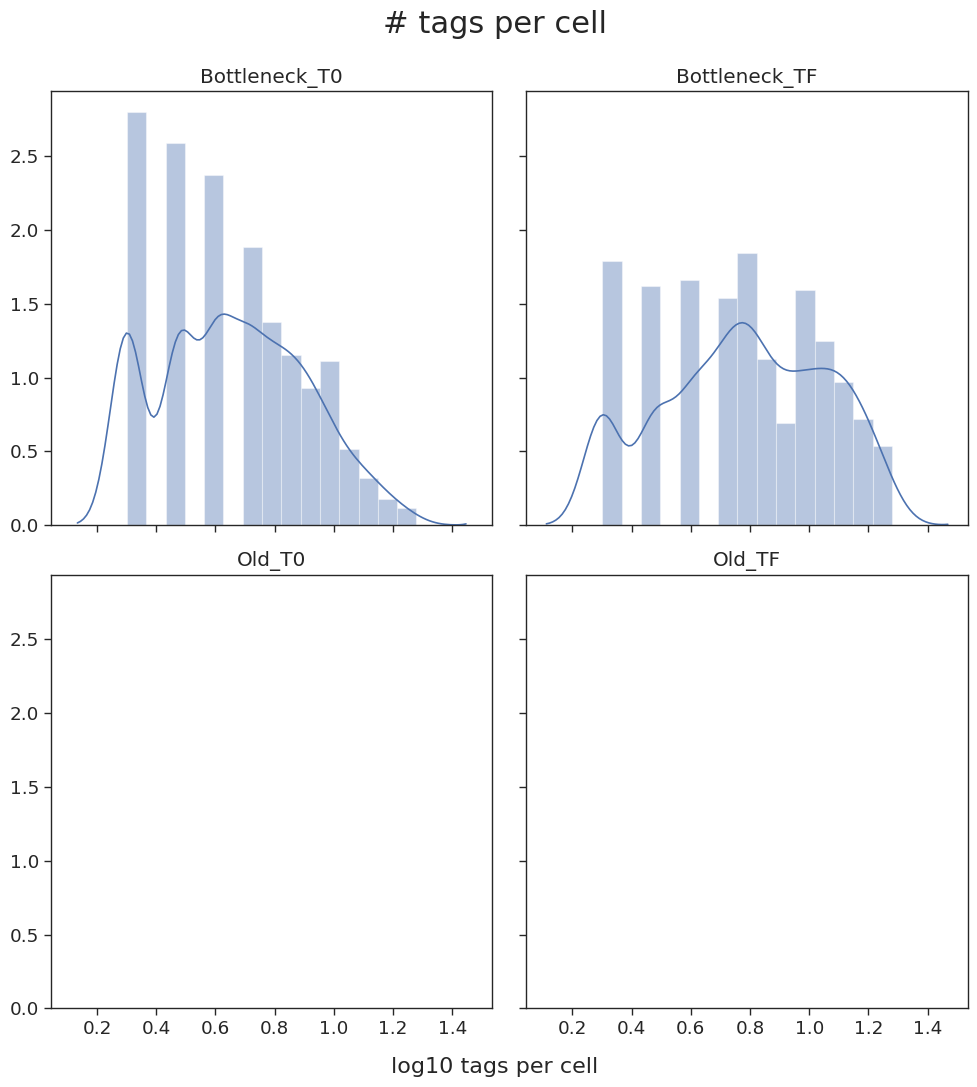

In [15]:
# v1 tags
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True, facecolor='white')

for i, SN in enumerate(treatments):
    print(SN)
    tags_per_cell = np.log10(combined_bin_dict[SN].sum(axis=1))
    weights = np.ones_like(tags_per_cell)/float(len(tags_per_cell))
    
    if i < 2:
        row_idx, col_idx = 0, i
    else:
        row_idx, col_idx = 1, i-2

    cur_ax = axes[row_idx, col_idx]
    sns.distplot(tags_per_cell, bins=15, ax=cur_ax)
    #axes[i].hist(tags_per_cell, weights=weights*100, bins=10)
    cur_ax.set_title(SN)

fig.tight_layout()
fig.text(0.5, -0.02, 'log10 tags per cell', ha='center', fontsize=16)
#fig.text(-0.02, 0.5, '% cells', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.02, '# tags per cell', ha='center', fontsize=22)

In [16]:
# mean tags per cell
for i, SN in enumerate(treatments):
    mean_unique_tags = combined_bin_dict[SN].sum(axis=1).mean()
    
    print('{}: {}'.format(SN, mean_unique_tags))

Bottleneck_T0: 5.315741583257507
Bottleneck_TF: 7.201531833413116
Old_T0: nan
Old_TF: nan


Bottleneck_T0
Bottleneck_TF
Old_T0
Old_TF


Text(0.5, 1.02, '# cells per tag')

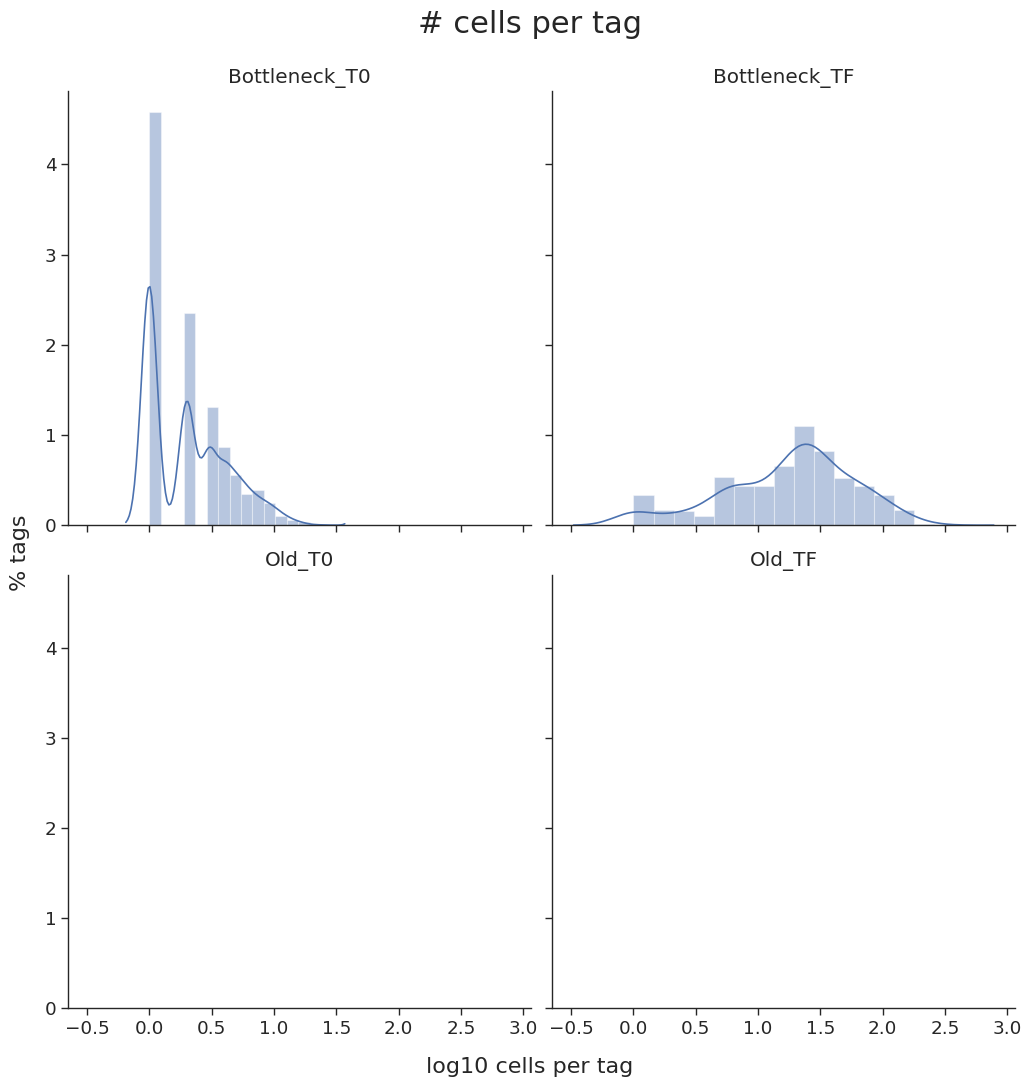

In [17]:
# check number of cells per tag
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True, facecolor='white')

for i, SN in enumerate(treatments):
    print(SN)
    cell_counts = np.log10(combined_bin_dict[SN].sum(axis=0))
    weights = np.ones_like(cell_counts)/len(cell_counts)*100
    
    if i < 2:
        row_idx, col_idx = 0, i
    else:
        row_idx, col_idx = 1, i-2

    cur_ax = axes[row_idx, col_idx]
    sns.distplot(cell_counts, bins=15, ax=cur_ax)
    #axes[i].hist(tags_per_cell, weights=weights*100, bins=10)
    cur_ax.set_title(SN)
    sns.despine()

fig.tight_layout()
fig.text(0.5, -0.02, 'log10 cells per tag', ha='center', fontsize=16)
fig.text(-0.02, 0.5, '% tags', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.02, '# cells per tag', ha='center', fontsize=22)

Text(0.5, 1.02, 'detected expression level of tags across cells')

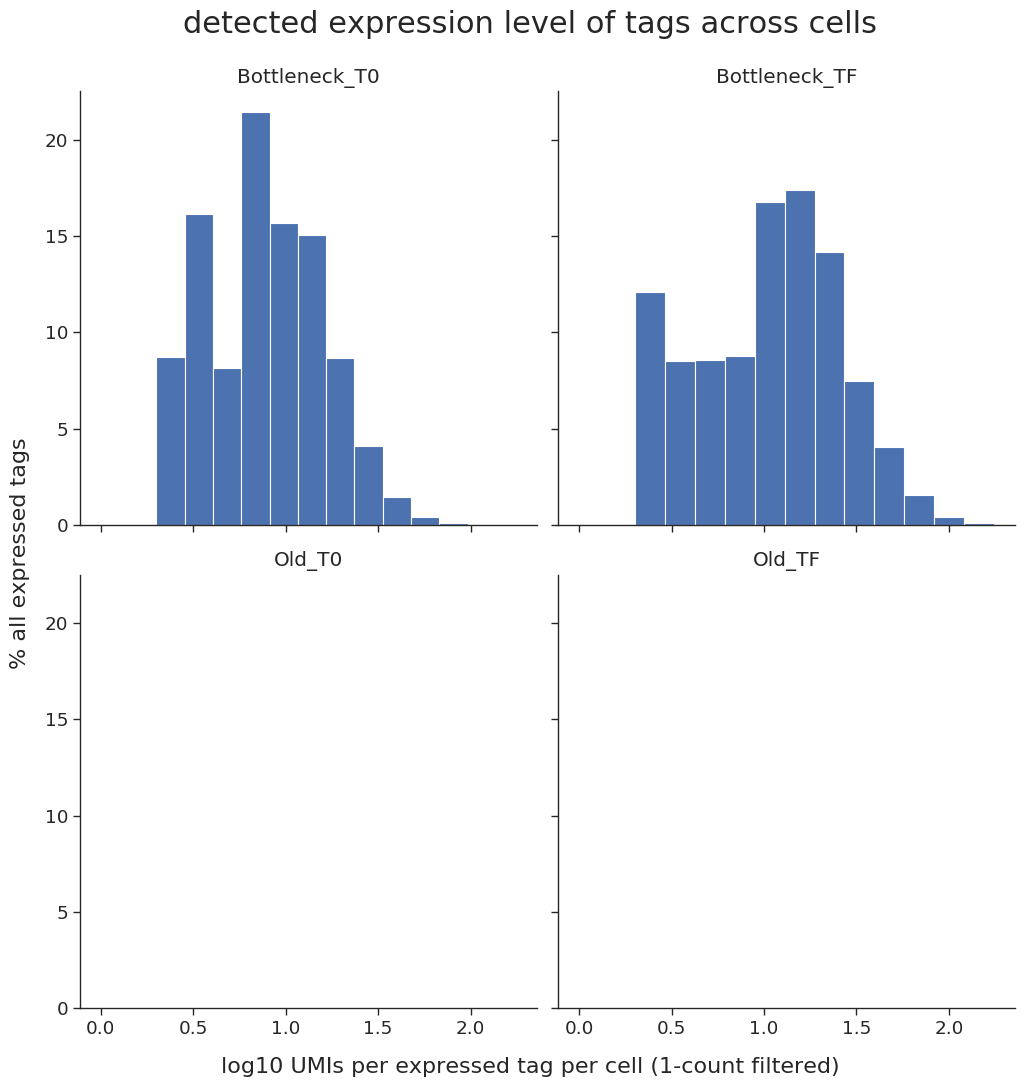

In [18]:
# expression level
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True)

for i, SN in enumerate(treatments):
    idx_to_use = combined_bin_dict[SN].index
    v_counts = combined_counts_dict[SN].copy()
    v_counts = v_counts.loc[idx_to_use, :]
    
    vals = np.log10(np.ravel(v_counts.values[v_counts.values > 1]))
    weights = np.ones_like(vals)/len(vals)*100
    
    if i < 2:
        row_idx, col_idx = 0, i
    else:
        row_idx, col_idx = 1, i-2

    cur_ax = axes[row_idx, col_idx]
    cur_ax.hist(vals, weights=weights, bins=12);
    cur_ax.set_title(SN)
    sns.despine()

fig.tight_layout()
fig.text(0.5, -0.02, 'log10 UMIs per expressed tag per cell (1-count filtered)', ha='center', fontsize=16)
fig.text(-0.02, 0.5, '% all expressed tags', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.02, 'detected expression level of tags across cells', ha='center', fontsize=22)

Bottleneck_T0
Bottleneck_TF
Old_T0
Old_TF


Text(0.5, 1.02, '# tags per cell boxplots')

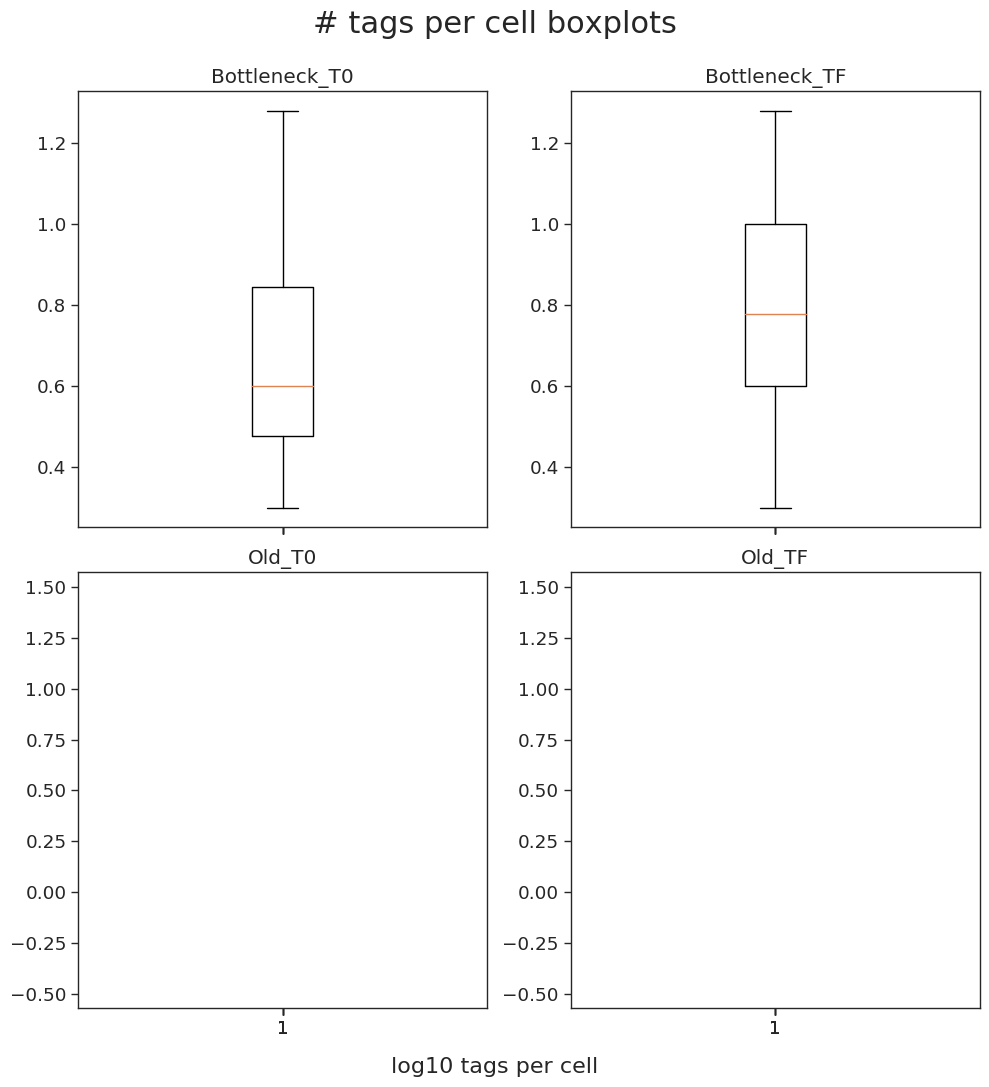

In [19]:
# v1 tags
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True)

for i, SN in enumerate(treatments):
    print(SN)
    tags_per_cell = np.log10(combined_bin_dict[SN].sum(axis=1))
    
    if i < 2:
        row_idx, col_idx = 0, i
    else:
        row_idx, col_idx = 1, i-2

    cur_ax = axes[row_idx, col_idx]
    cur_ax.boxplot(tags_per_cell)
    cur_ax.set_title(SN)

fig.tight_layout()
fig.text(0.5, -0.02, 'log10 tags per cell', ha='center', fontsize=16)
fig.text(0.5, 1.02, '# tags per cell boxplots', ha='center', fontsize=22)

## Jaccard similarity and clone calling

In [20]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering

In [21]:
# calculate jaccard similarity between cells
jacc_dict = dict()
for sample in treatments[:2]:
    jacc_dict[sample] = 1 - pairwise_distances(combined_bin_dict[sample].values, metric='jaccard')

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


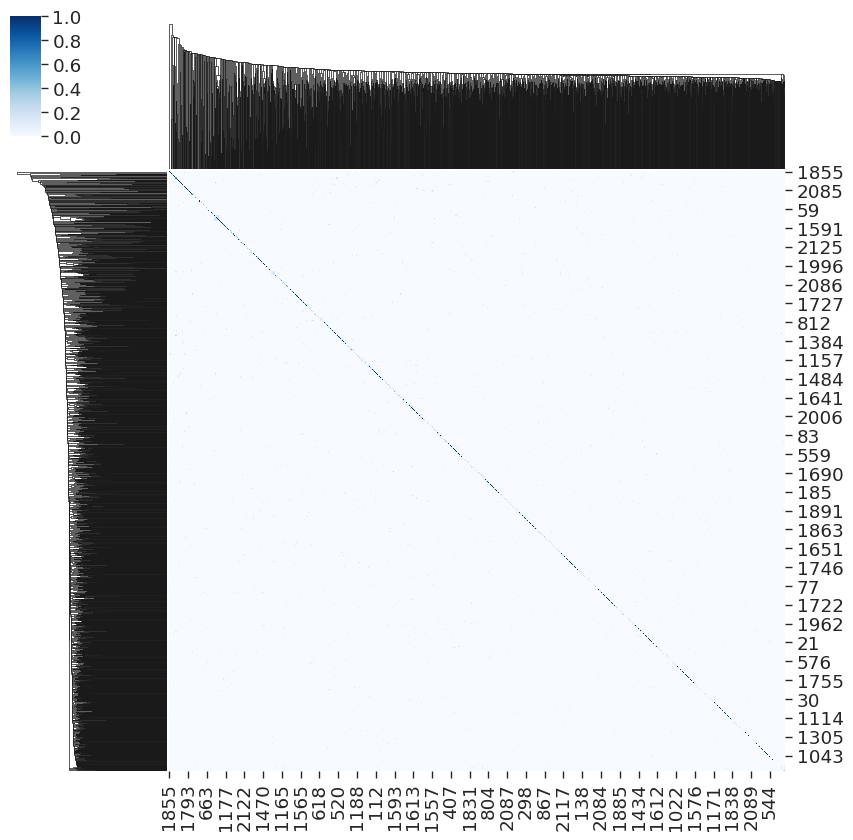

In [22]:
# plot pairwise jaccard similarity for celltag
p_0 = sns.clustermap(jacc_dict['Bottleneck_T0'], cmap=matplotlib.cm.Blues)

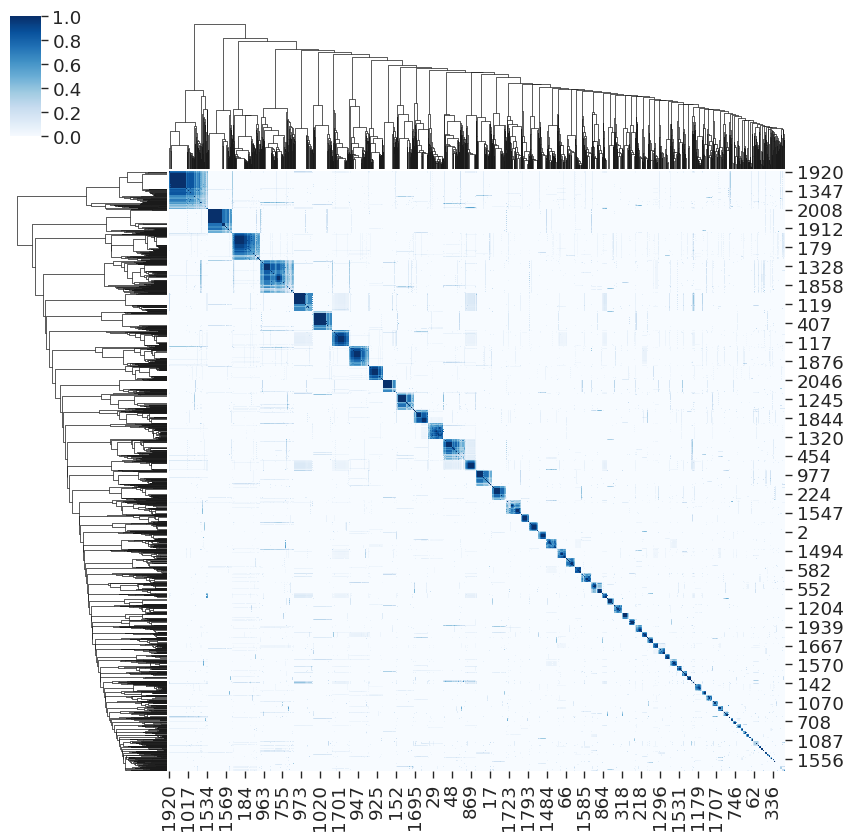

In [23]:
# plot pairwise jaccard similarity for celltag
p_dmso = sns.clustermap(jacc_dict['Bottleneck_TF'], cmap=matplotlib.cm.Blues)

In [ ]:
tmp = combined_bin_dict['Bottleneck_TF'].iloc[p_dmso.dendrogram_row.reordered_ind[:100], :]

In [ ]:
tmp = tmp.loc[:, (tmp > 0).any(axis=0)]

In [ ]:
tmp = tmp.loc[:, tmp.sum(axis=0).sort_values(ascending=False).index]

In [ ]:
tmp.sum(axis=0)

In [ ]:
len(tmp.columns)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(32, 8), facecolor='white')
a = combined_counts_dict['Bottleneck_TF'].loc[tmp.index, tmp.columns].values
#a = tmp.values
plt.imshow(a, cmap='Reds', interpolation='nearest')
plt.xlabel('Tags', fontsize=32)
plt.ylabel('Cells', fontsize=32)
plt.title('Expression of Tags', fontsize=28)
plt.colorbar()
plt.show()

In [ ]:
# 54 cells in the initial 'cluster', 52 of them share the same single tag, then overlapping between other tags is very little
# one shared tag = ambient
#idx_to_check = combined_bin_dict['new:D8_DMSO']['v1'].iloc[p_dmso.data2d.index[:54], :].index
#tmp = combined_bin_dict['new:D8_DMSO']['v1'].loc[idx_to_check, :]
#tmp = tmp.loc[:, tmp.sum(axis=0) > 0]
#sorted(tmp.sum(axis=0), reverse=True)

In [24]:
# convert jaccard to binary clone matrix
bin_clone_dict = dict()
for sample in jacc_dict:
    bin_clone_dict[sample] = jacc_dict[sample].copy()
    bin_clone_dict[sample][bin_clone_dict[sample] < 0.7] = 0
    bin_clone_dict[sample][bin_clone_dict[sample] > 0] = 1

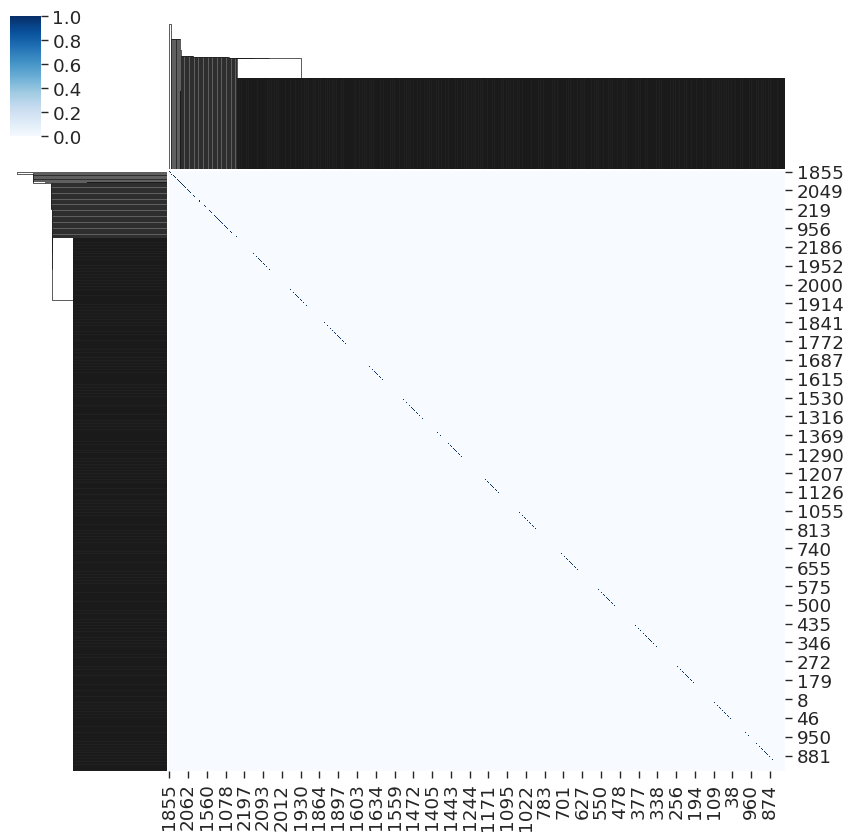

In [25]:
# plot pairwise jaccard similarity for celltag
sns.clustermap(bin_clone_dict['Bottleneck_T0'], cmap=matplotlib.cm.Blues)

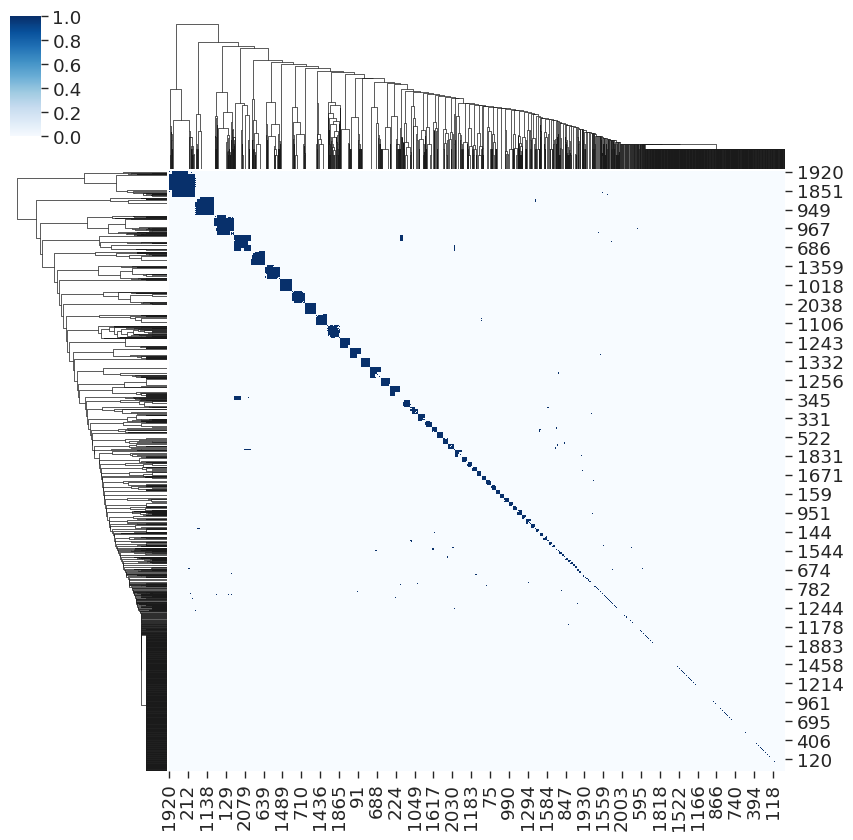

In [26]:
# plot pairwise jaccard similarity for celltag
sns.clustermap(bin_clone_dict['Bottleneck_TF'], cmap=matplotlib.cm.Blues)

## Clone analysis

### Observations
First set all 1-entires in the count matrix to 0, based on the rationale that ambient celltag that got picked up accidentally would likely just have 1 UMI count. The resulting clonal analysis showed that real cell tag could have 1 molecule count in some or all cells in the clone.

As a result, the 1-entry filter was removed but then it seems like some ambient tags did creep in. Moreover, it is observed that some ambient tags could have UMI count higher than 1, since cells grouped by an ambient tag share no other tag with each other.

# algorithm

In [ ]:
def overlap_distance(x, y):
    return (1 - np.dot(x, y) / np.min([np.sum(x), np.sum(y)]))

In [ ]:
# distance matrix
D = pairwise_distances(combined_bin_dict['Bottleneck_TF'], metric=overlap_distance)

In [ ]:
# plot pairwise jaccard similarity for celltag
p_dmso = sns.clustermap(1-D, cmap=matplotlib.cm.Blues)